In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict, Counter
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import math
import time
import random

import torch
import torchvision

import torch.nn as nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, AnchorGenerator
from torchvision.transforms import functional as F
import torchvision.transforms as transforms
from torchvision.ops import box_iou

from torch.utils.data import Dataset, DataLoader, Sampler

from PIL import Image

In [2]:
DATA_ROOT = r'/bdd-10k/bdd-10k'

train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "val")
test_dir = os.path.join(DATA_ROOT, "val")

train_labels_dir = os.path.join(train_dir, "ann")
train_images_dir = os.path.join(train_dir, "img")

val_labels_dir = os.path.join(val_dir, "ann")
val_images_dir = os.path.join(val_dir, "img")

In [3]:
print(train_labels_dir)
print(val_labels_dir)

/kaggle/input/datasets/bngtiutr/bdd-10k/bdd-10k/train/ann
/kaggle/input/datasets/bngtiutr/bdd-10k/bdd-10k/val/ann


# EDA

In [4]:
present_images = set(os.listdir(train_labels_dir))
print(len(present_images))
count = 0
for item in present_images:
    print(item)
    count += 1
    if count >= 10:
        break

7000
0f5f84ef-5d520000.jpg.json
2cc27873-1866aa6a.jpg.json
7023e3a7-d9ccd3a4.jpg.json
2fd79f6e-8348aac9.jpg.json
4ffc2e24-a5d25ce4.jpg.json
0ce5101a-319adcd7.jpg.json
6a13353e-5b3d4c47.jpg.json
0a022bf4-abaf66af.jpg.json
6188b7cc-8e1f5358.jpg.json
39f03bbf-7052ffcf.jpg.json


In [5]:
def count_class_distribution(label_dir: str):

    class_counts = Counter()
    geometry_counts = Counter()

    for filename in tqdm(os.listdir(label_dir)):
        if filename.endswith(".json"):
            with open(os.path.join(label_dir, filename), 'r') as f:
                data = json.load(f)
                
                # In this format, objects are in the 'objects' list
                for obj in data.get('objects', []):
                    g_type = obj.get('geometryType')
                    class_name = obj.get('classTitle')
                    
                    # We only want to count the bounding boxes (rectangles)
                    if g_type == 'rectangle':
                        class_counts[class_name] += 1
                    
                    geometry_counts[g_type] += 1
    
    print(f"Summary of Geometries found:")
    for g_type, count in geometry_counts.items():
        print(f"- {g_type:10}: {count}")
    
    print("\nObject Detection Class Distribution (Rectangles only):")
    print("-" * 40)
    for category, count in class_counts.most_common():
        print(f"{category:20}: {count}")

count_class_distribution(train_labels_dir)

100%|██████████| 7000/7000 [00:29<00:00, 234.66it/s]

Summary of Geometries found:
- polygon   : 90196
- rectangle : 89165

Object Detection Class Distribution (Rectangles only):
----------------------------------------
car                 : 71647
pedestrian          : 9933
truck               : 3738
bus                 : 1633
bicycle             : 818
rider               : 468
motorcycle          : 396
caravan             : 359
trailer             : 108
train               : 65


In [6]:
count_class_distribution(val_labels_dir)

100%|██████████| 1000/1000 [00:04<00:00, 237.60it/s]

Summary of Geometries found:
- polygon   : 13195
- rectangle : 12996

Object Detection Class Distribution (Rectangles only):
----------------------------------------
car                 : 10824
pedestrian          : 1176
truck               : 520
bus                 : 219
bicycle             : 99
caravan             : 52
motorcycle          : 47
rider               : 45
train               : 7
trailer             : 7


Analyzing Train...


100%|██████████| 7000/7000 [00:08<00:00, 803.61it/s]


Analyzing Val...


100%|██████████| 1000/1000 [00:01<00:00, 807.10it/s]


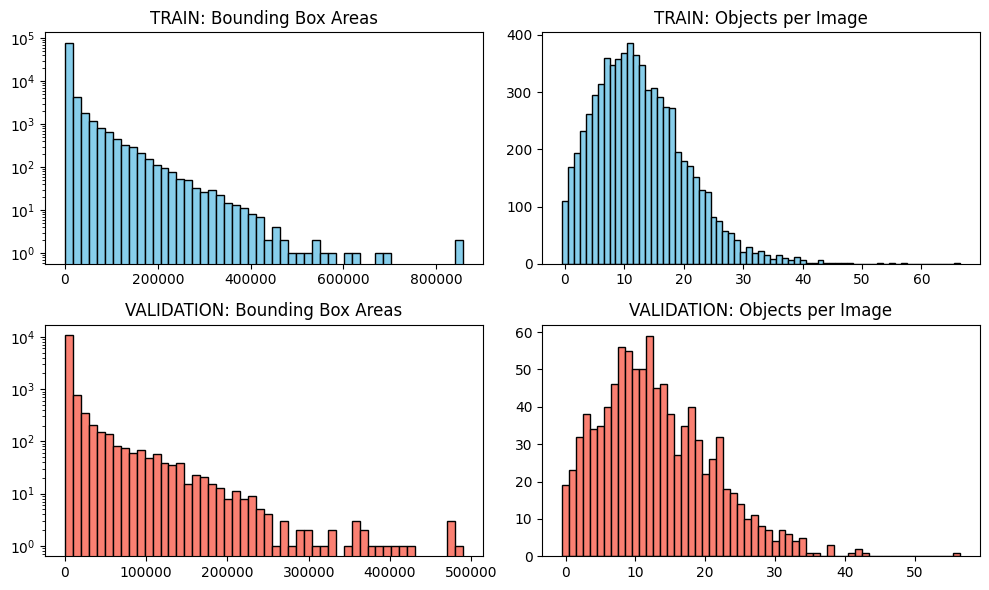


TRAIN: 7000 imgs | 109 empty | 89165 boxes | Avg: 12.7

VAL: 1000 imgs | 19 empty | 12996 boxes | Avg: 13.0


In [7]:
def analyze_dataset(ann_dir, split_name):
    box_areas, obj_counts, empty_count = [], [], 0
    
    print(f"Analyzing {split_name}...")
    files = [f for f in os.listdir(ann_dir) if f.endswith(".json")]
    
    for f_name in tqdm(files):
        with open(os.path.join(ann_dir, f_name), 'r') as f:
            objects = json.load(f).get('objects', [])
            
            # Filter for bounding boxes
            rects = [o for o in objects if o.get('geometryType') == 'rectangle']
            count = len(rects)
            
            obj_counts.append(count)
            if count == 0: empty_count += 1
            
            for r in rects:
                p1, p2 = r['points']['exterior']
                box_areas.append(abs(p2[0]-p1[0]) * abs(p2[1]-p1[1]))
    
    return {"areas": box_areas, "counts": obj_counts, "empty": empty_count, "total": len(obj_counts)}


train_res = analyze_dataset(train_labels_dir, "Train")
val_res = analyze_dataset(val_labels_dir, "Val")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Helper function to plot row
def plot_row(row_idx, stats, name, color):
    # Area Histogram
    axes[row_idx, 0].hist(stats['areas'], bins=50, color=color, edgecolor='black')
    axes[row_idx, 0].set_title(f'{name}: Bounding Box Areas')
    axes[row_idx, 0].set_yscale('log')
    
    # Objects per Image Histogram
    axes[row_idx, 1].hist(stats['counts'], bins=range(max(stats['counts'])+2), color=color, edgecolor='black', align='left')
    axes[row_idx, 1].set_title(f'{name}: Objects per Image')

plot_row(0, train_res, "TRAIN", "skyblue")
plot_row(1, val_res, "VALIDATION", "salmon")

plt.tight_layout()
plt.show()

# Quick summary print
for s, n in [(train_res, "TRAIN"), (val_res, "VAL")]:
    print(f"\n{n}: {s['total']} imgs | {s['empty']} empty | {len(s['areas'])} boxes | Avg: {np.mean(s['counts']):.1f}")

# Analysis

**Train vs Val proportions are highly consistent**
-> No major distribution shift between train and validation.

- Model will overfit to “car”
- Rare classes (train, trailer) will have near-zero recall
- Loss will be dominated by car anchors in RPN + classifier

- Train: 12.7 avg
- Val: 13.0 avg
  
**-> Each image has ~13 objects**

**Train: 109 empty (1.5%) -- Val: 19 empty (1.9%)**
Empty images: ~2.0% in both sets

**Should keep empty images in the dataset.**
- Improves background learning
- Reduces false positives



# Ideas to Consider :

- Annotation Filtering (Remove the polygon annotations or just ignore them)
- Handle Empty Images correctly.
- Small Bounding Box Filtering because tiny boxes cause unstable RPN anchor matching.
- What is class mapping strategy? Especially for the extremely rare classes?
- Class Imbalance Mitigation?

# Begin Preparing Dataset

In [8]:
class BDD10KDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split="train", transforms=None,
                 min_box_area=0, class_map=None):
        """
        Args:
            root_dir: path to bdd10k folder
            split: 'train', 'val', or 'test'
            transforms: augmentation/transforms
            min_box_area: filter tiny boxes (e.g., 16 or 32)
            class_map: dict mapping classTitle -> int label
        """
        self.root_dir = root_dir
        self.split = split
        self.transforms = transforms
        self.min_box_area = min_box_area

        self.img_dir = os.path.join(root_dir, split, "img")
        self.ann_dir = os.path.join(root_dir, split, "ann")

        self.image_files = sorted([
            f for f in os.listdir(self.img_dir) if f.endswith(".jpg")
        ])

        # Default class map
        if class_map is None:
            self.class_map = {
                "car": 1,
                "pedestrian": 2,
                "truck": 3,
                "bus": 4,
                "bicycle": 5,
                "rider": 6,
                "motorcycle": 7,
                "caravan": 8,
                "trailer": 9,
                "train": 10,
            }
        else:
            self.class_map = class_map


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
    
        ann_name = img_name + ".json"
        ann_path = os.path.join(self.ann_dir, ann_name)
    
        # Load image 
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
    
        # Load annotations
        with open(ann_path, "r") as f:
            ann_data = json.load(f)
    
        objects = ann_data.get("objects", [])
    
        boxes = []
        labels = []
    
        # Parse and filter annotations (BDD100K specific)
        for obj in objects:
            # Ignore polygons
            if obj.get("geometryType") != "rectangle":
                continue
    
            class_title = obj.get("classTitle")
    
            # Skip unknown classes
            if class_title not in self.class_map:
                continue
    
            # BDD100K bbox format: [[x1, y1], [x2, y2]]
            (x1, y1), (x2, y2) = obj["points"]["exterior"]
    
            xmin = min(x1, x2)
            ymin = min(y1, y2)
            xmax = max(x1, x2)
            ymax = max(y1, y2)
    
            # Filter invalid / tiny boxes for RPN stability
            w = xmax - xmin
            h = ymax - ymin
            if w <= 0 or h <= 0:
                continue
    
            if (w * h) < self.min_box_area:
                continue
    
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_map[class_title])
    
        # Apply transforms BEFORE tensor conversion
        if self.transforms is not None:
            transformed = self.transforms(
                image=img_np,
                bboxes=boxes,
                labels=labels
            )
            img = transformed["image"]  # tensor (C, H, W)
            boxes = transformed["bboxes"]
            labels = transformed["labels"]
        else:
            # Convert PIL/numpy image to float tensor in [0, 1]
            img = torch.from_numpy(img_np).permute(2, 0, 1)
            img = img.to(torch.float32) / 255.0
    
        # Convert boxes/labels to tensors AFTER transforms
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
    
            # Are is computed AFTER transforms (flip/resize safe)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
    
        # Build target 
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(idx),
            "area": area,
            "iscrowd": iscrowd,
            "img_path": img_path
        }
    
        return img, target

# Data Augmenation using Albumentations

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.MotionBlur(p=0.1),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels']
    ))


def get_val_transforms():
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Utilities

In [10]:
# Config

BATCH_SIZE = 2

# Hyperparameters
RANDOM_SEED = 18
LEARNING_RATE = 0.001
MOMENTUM=0.9
WEIGHT_DECAY_RATE = 0.0005


NUM_EPOCHS = 15

# Warmup for 500 iterations
WARMUP_ITERS = 500


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# For reproducibility
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

CLASSES = [
    "__background__",
    "car",
    "pedestrian",
    "truck",
    "bus",
    "bicycle",
    "rider",
    "motorcycle",
    "caravan",
    "trailer",
    "train",
]

CLASS_MAP = {cls: i for i, cls in enumerate(CLASSES) if i != 0}

print(CLASS_MAP)
print(f"DEVICE: {device}")

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Default is ((32,), (64,), (128,), (256,), (512,)). However, detecting pedestrians require smaller boxes, and also larger boxes are not needed.
    anchor_sizes = (
        (16,),  # Level 1 (Smallest features, distant objects)
        (32,),  # Level 2
        (64,),  # Level 3
        (128,), # Level 4
        (256,), # Level 5 (Largest features)
    )
    
    # Must also provide aspect ratios for each of the 5 levels.
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

    # Replace the RPN anchor generator
    model.rpn.anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_iters, warmup_factor=0.01, last_epoch=-1):
        self.warmup_iters = warmup_iters
        self.warmup_factor = warmup_factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch >= self.warmup_iters:
            return [base_lr for base_lr in self.base_lrs]

        alpha = float(self.last_epoch) / float(self.warmup_iters)
        factor = self.warmup_factor * (1 - alpha) + alpha
        return [base_lr * factor for base_lr in self.base_lrs]


def compute_map50(model, val_loader, device, iou_threshold=0.5, score_threshold=0.05):
    print("\n[INFO] Starting mAP@0.5 evaluation...")
    model.eval()

    # Storage for all predictions and GT (per class)
    all_predictions = {c: [] for c in range(1, len(CLASSES))}
    all_gts = {c: [] for c in range(1, len(CLASSES))}

    # ---- SINGLE PASS THROUGH DATASET (CRITICAL FIX) ----
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Running inference for mAP"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            preds = outputs[0]
            gt = targets[0]

            pred_boxes = preds["boxes"].cpu()
            pred_labels = preds["labels"].cpu()
            pred_scores = preds["scores"].cpu()

            gt_boxes = gt["boxes"].cpu()
            gt_labels = gt["labels"].cpu()

            # Store per-class predictions and GT
            for class_id in range(1, len(CLASSES)):  # skip background
                pred_mask = pred_labels == class_id
                gt_mask = gt_labels == class_id

                all_predictions[class_id].append({
                    "boxes": pred_boxes[pred_mask],
                    "scores": pred_scores[pred_mask]
                })

                all_gts[class_id].append({
                    "boxes": gt_boxes[gt_mask]
                })

    print("[INFO] Inference finished. Computing AP per class...")

    # ---- COMPUTE AP PER CLASS (CPU ONLY) ----
    all_ap = []

    for class_id in tqdm(range(1, len(CLASSES)), desc="Computing AP per class"):
        true_positives = []
        scores = []
        num_gt = 0

        class_preds = all_predictions[class_id]
        class_gts = all_gts[class_id]

        for preds, gts in zip(class_preds, class_gts):
            pred_boxes = preds["boxes"]
            pred_scores = preds["scores"]
            gt_boxes = gts["boxes"]

            num_gt += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue

            # Sort predictions by confidence (descending)
            sorted_idx = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[sorted_idx]
            pred_scores = pred_scores[sorted_idx]

            matched = torch.zeros(len(gt_boxes))

            for pb, ps in zip(pred_boxes, pred_scores):
                scores.append(ps.item())

                if len(gt_boxes) == 0:
                    true_positives.append(0)
                    continue

                ious = box_iou(pb.unsqueeze(0), gt_boxes).squeeze(0)
                max_iou, max_idx = torch.max(ious, dim=0)

                if max_iou >= iou_threshold and matched[max_idx] == 0:
                    true_positives.append(1)
                    matched[max_idx] = 1
                else:
                    true_positives.append(0)

        if num_gt == 0 or len(true_positives) == 0:
            continue

        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # Sort by confidence
        sorted_indices = np.argsort(-scores)
        true_positives = true_positives[sorted_indices]

        cum_tp = np.cumsum(true_positives)
        precision = cum_tp / (np.arange(len(cum_tp)) + 1)
        recall = cum_tp / num_gt

        ap = np.trapz(precision, recall)
        all_ap.append(ap)

        # print(f"[DEBUG] Class {class_id} AP@0.5: {ap:.4f}")

    map50 = np.mean(all_ap) if len(all_ap) > 0 else 0.0

    print(f"mAP@0.5 Computation Complete: {map50:.4f}\n")
    
    return map50

{'car': 1, 'pedestrian': 2, 'truck': 3, 'bus': 4, 'bicycle': 5, 'rider': 6, 'motorcycle': 7, 'caravan': 8, 'trailer': 9, 'train': 10}
DEVICE: cuda


In [12]:
# Handle Class Imbalance

def compute_repeat_factors(dataset, repeat_thresh=0.01):
    """
    Computes Repeat Factor Sampling weights for BDD-style dataset
    (one JSON per image).
    """
    
    class_image_count = defaultdict(int)
    image_classes = []
    
    # Iterate exactly how dataset is indexed
    for idx in range(len(dataset)):
        img_name = dataset.image_files[idx]
        ann_path = os.path.join(dataset.ann_dir, img_name + ".json")
        
        with open(ann_path, "r") as f:
            ann_data = json.load(f)
        
        objects = ann_data.get("objects", [])
        classes_in_image = set()
        
        for obj in objects:
            if obj.get("geometryType") != "rectangle":
                continue
            
            class_title = obj.get("classTitle")
            if class_title not in dataset.class_map:
                continue
            
            classes_in_image.add(dataset.class_map[class_title])
        
        image_classes.append(classes_in_image)
        
        for c in classes_in_image:
            class_image_count[c] += 1
    
    num_images = len(dataset)
    
    # Compute class frequency f_c
    class_freq = {
        c: count / num_images
        for c, count in class_image_count.items()
    }
    
    # Compute repeat factor r_c = max(1, sqrt(t / f_c))
    class_repeat = {
        c: max(1.0, math.sqrt(repeat_thresh / freq))
        for c, freq in class_freq.items()
    }
    
    # Compute per-image repeat factor r_I = max r_c in image
    image_repeat_factors = []
    for classes in image_classes:
        if len(classes) == 0:
            image_repeat_factors.append(1.0)
        else:
            r = max(class_repeat[c] for c in classes)
            image_repeat_factors.append(r)
    
    return image_repeat_factors


class RepeatFactorSampler(Sampler):
    def __init__(self, repeat_factors):
        """
        repeat_factors: list[float] of length = len(dataset)
        """
        self.repeat_factors = repeat_factors

    def __iter__(self):
        indices = []
        for idx, r in enumerate(self.repeat_factors):
            int_part = int(r)
            frac_part = r - int_part
            count = int_part + (1 if random.random() < frac_part else 0)
            indices.extend([idx] * count)

        random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        # Expected length (not exact per epoch)
        return int(sum(self.repeat_factors))

In [13]:
def vis_bbox(img, output, classes, max_vis=40, prob_thres=0.5):
    """
    img: PIL Image (NOT tensor)
    output: model prediction dict
    classes: CLASSES list
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(img)

    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    labels = output["labels"].cpu().numpy()

    num_boxes = min(len(boxes), max_vis)

    for i in range(num_boxes):
        if scores[i] < prob_thres:
            continue

        x1, y1, x2, y2 = boxes[i]
        label_id = labels[i]
        class_name = classes[label_id]

        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor='purple',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(
            x1, y1 - 5,
            f"{class_name}: {scores[i]:.2f}",
            color='white',
            fontsize=10,
            bbox=dict(facecolor='purple', alpha=0.5)
        )

    plt.axis("off")
    plt.show()
    plt.close()


IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])


def denormalize(img_tensor):
    """
    img_tensor: (C, H, W) normalized tensor
    returns: tensor in [0,1] suitable for visualization
    """
    mean = IMAGENET_MEAN[:, None, None]
    std = IMAGENET_STD[:, None, None]
    img = img_tensor * std + mean
    return img.clamp(0, 1)


def evaluate_loss(model, val_loader, device):
    was_training = model.training
    model.train()

    val_loss = 0.0
    valid_batches = 0

    print("Evaluating Loss on Validation Set")

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [
                {k: v.to(device) for k, v in t.items() if isinstance(v, torch.Tensor)}
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss_dict.values())

            val_loss += losses.item()
            valid_batches += 1

    if not was_training:
        model.eval()

    return val_loss / max(valid_batches, 1)

# Train & Evaluation

In [ ]:
def main():
    train_dataset = BDD10KDataset(
        root_dir=DATA_ROOT,
        split="train",
        transforms=get_train_transforms(),      
        class_map=CLASS_MAP,
        min_box_area=4            
    )

    val_dataset = BDD10KDataset(
        root_dir=DATA_ROOT,
        split="val",
        class_map=CLASS_MAP,
        transforms=get_val_transforms()
    )


    # Compute repeat factors (once before training)
    repeat_factors = compute_repeat_factors(
        train_dataset,
        repeat_thresh=0.075
    )
    
    train_sampler = RepeatFactorSampler(repeat_factors)

    # Log the change in dataset size
    print(f"Original Dataset Size: {len(train_dataset)}")
    print(f"RFS 'Virtual' Dataset Size: {len(train_sampler)}")

    print("Repeat Factor Stats:")
    print(f"Min: {np.min(repeat_factors):.3f}")
    print(f"Mean: {np.mean(repeat_factors):.3f}")
    print(f"Max: {np.max(repeat_factors):.3f}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,            
        # shuffle=True, <- Unnecessary because there sampler is responsible for sampling.
        collate_fn=collate_fn,
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    # Model
    model = get_model(num_classes=len(CLASSES))
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY_RATE
    )
    
    warmup_scheduler = WarmupScheduler(optimizer, warmup_iters=WARMUP_ITERS)
    
    # Main LR scheduler (after warmup)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=4,
        gamma=0.5
    )

    global_step = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        valid_batches = 0
    
        for images, targets in tqdm(train_loader):
            valid_batches += 1
            global_step += 1  # <-- for warmup
    
            images = [img.to(device) for img in images]
    
            targets_to_device = [
                {k: v.to(device) for k, v in t.items() if isinstance(v, torch.Tensor)}
                for t in targets
            ]
    
            loss_dict = model(images, targets_to_device)
            losses = sum(loss for loss in loss_dict.values())
    
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    
            # ---- Warmup step (per iteration) ----
            if global_step <= WARMUP_ITERS:
                warmup_scheduler.step()
    
            epoch_loss += losses.item()
    
        # Step main scheduler AFTER epoch (unchanged)
        lr_scheduler.step()

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss/max(valid_batches, 1):.4f}")

         # ---- Validation Loss Evaluation ----
        val_loss = evaluate_loss(model, val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}")
        
        # ---- mAP@0.5 Evaluation (every 3 epochs to save time) ----
        if (epoch + 1) % 3 == 0:
            map50 = compute_map50(model, val_loader, device)

        # ---- Save model every 3 epochs ----
        if (epoch + 1) % 3 == 0:
            print(f"Saving model after {epoch + 1} epoch(s)")
            torch.save(
                model.state_dict(),
                f"fasterrcnn_bdd_epoch_{epoch+1}.pth"
            )

        # ---- Random Visualization (3 random images each epoch) ----
        model.eval()

        rand_indices = random.sample(range(len(val_dataset)), k=3)

        with torch.no_grad():
            for idx in rand_indices:
                img, _ = val_dataset[idx]
                img_tensor = img.to(device)

                outputs = model([img_tensor])

                # De-normalize for visualization
                img_denorm = denormalize(img.cpu())
                img_vis = transforms.ToPILImage()(img_denorm)

                vis_bbox(img_vis, outputs[0], CLASSES, prob_thres=0.5)

main()

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Original Dataset Size: 7000
RFS 'Virtual' Dataset Size: 7506
Repeat Factor Stats:
Min: 1.000
Mean: 1.072
Max: 3.307
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 224MB/s] 
  9%|▉         | 332/3753 [01:47<18:08,  3.14it/s]